In [231]:
import matplotlib.pyplot as plt
import json
from Bio import SeqIO
import subprocess
import random
import os
from tqdm import tqdm, trange
import math
import scipy.stats as stats
from statistics import median


In [232]:
# Due to high computing time, limit aggregation and disorder analysis to set number of species
number_of_random_species = 100


In [233]:
def calculate_report(hom, trg, orf):
    print(
        f"hom > trg p-value: {stats.mannwhitneyu(x=hom, y=trg, alternative = 'greater').pvalue} "
    )
    print(
        f"trg > orf p-value: {stats.mannwhitneyu(x=trg, y=orf, alternative = 'greater').pvalue} "
    )
    print(
        f"hom < trg p-value: {stats.mannwhitneyu(x=hom, y=trg, alternative = 'less').pvalue} "
    )
    print(
        f"trg < orf p-value: {stats.mannwhitneyu(x=trg, y=orf, alternative = 'less').pvalue} "
    )
    print(f"medians: \n\thom {median(hom)} \n\ttrg {median(trg)} \n\torf {median(orf)}")


In [234]:
def get_aggreagtion_results(file_path):
    temp_file = "temp.txt"
    # file_path = "../large_data/example.fasta"
    tango_file_path = "../large_data/tango2_3_1.linux64/tango_x86_64_release"
    records = (r for r in SeqIO.parse(file_path, "fasta"))

    aggregation_scores = list()
    for r in records:
        with open(temp_file, "w") as f:
            f.write(f"tempseq N N 7 298 0.1 {r.seq}\n")

        result = subprocess.run(
            [
                tango_file_path,
                f"-inputfile={temp_file}",
            ],
            capture_output=True,
        )

        with open("tempseq.txt", "r") as f:
            f.readline()
            aggregation_scores.append([float(line.split("\t")[5]) for line in f])
    results = [sum(x) / len(x) for x in aggregation_scores]
    os.system("rm temp_aggregation*")
    return results


In [235]:
with open("../data/species_list.json") as json_file:
    available_species_list = json.load(json_file)

aggregation_orf_results = list()
aggregation_trg_results = list()
aggregation_hom_results = list()
for i in trange(number_of_random_species):

    species = random.sample(available_species_list, 1)[0]

    available_species_list.remove(species)
    file_path = f"../large_data/protein_faa_reps/bacteria/{species}"
    aggregation_orf_results += get_aggreagtion_results(file_path + "_orfs.fasta")
    aggregation_trg_results += get_aggreagtion_results(file_path + "_clusters.fasta")
    aggregation_hom_results += get_aggreagtion_results(file_path + "_homologues.fasta")


100%|██████████| 100/100 [24:44<00:00, 14.84s/it]


In [236]:
print("AGGREGATION")
print(
    f"Number of sequences from each dataset: {len(aggregation_orf_results)}, total number of species: {number_of_random_species}"
)
calculate_report(
    aggregation_hom_results, aggregation_trg_results, aggregation_orf_results
)


AGGREGATION
Number of sequences from each dataset: 7017, total number of species: 100
hom > trg p-value: 1.90779569936432e-09 
trg > orf p-value: 8.102782518504454e-158 
hom < trg p-value: 0.9999999980922529 
trg < orf p-value: 1.0 
medians: 
	hom 1.1006931818181824 
	trg 0.6024193548387097 
	orf 0.0


In [237]:
def get_disorder_results(file_path):
    temp_file = "temp.txt"
    disorder_scores = list()
    for record in SeqIO.parse(file_path, "fasta"):
        with open(temp_file, "w") as f:
            SeqIO.write(record, f, "fasta")

        result = subprocess.run(
            [
                "python3",
                "../large_data/iupred2a/iupred2a.py",
                temp_file,
                "short",
            ],
            capture_output=True,
            text=True,
        )

        results = result.stdout.split("\n")
        results_floats = [float(x) for x in results if x != ""]
        disorder_scores.append(
            sum(i > 0.5 for i in results_floats) / len(results_floats)
        )
    return disorder_scores


In [238]:
with open("../data/species_list.json") as json_file:
    available_species_list = json.load(json_file)

disorder_orf_results = list()
disorder_trg_results = list()
disorder_hom_results = list()
for i in tqdm(range(number_of_random_species)):
    species = random.sample(available_species_list, 1)[0]
    available_species_list.remove(species)
    file_path = f"../large_data/protein_faa_reps/bacteria/{species}"
    disorder_orf_results += get_disorder_results(file_path + "_orfs.fasta")
    disorder_trg_results += get_disorder_results(file_path + "_clusters.fasta")
    disorder_hom_results += get_disorder_results(file_path + "_homologues.fasta")


100%|██████████| 100/100 [22:36<00:00, 13.57s/it]


In [239]:
print("DISORDER")
print(
    f"Number of sequences from each dataset: {len(disorder_orf_results)}, total number of species: {number_of_random_species}"
)
calculate_report(disorder_hom_results, disorder_trg_results, disorder_orf_results)


DISORDER
Number of sequences from each dataset: 5235, total number of species: 100
hom > trg p-value: 1.0 
trg > orf p-value: 1.0 
hom < trg p-value: 0.0 
trg < orf p-value: 0.0 
medians: 
	hom 0.06481481481481481 
	trg 0.16326530612244897 
	orf 0.5483870967741935


In [240]:
length_trg = [
    len(r.seq)
    for r in SeqIO.parse("../large_data/longest_seqs_from_clusters.fasta", "fasta")
]
length_homologues = [
    len(r.seq) for r in SeqIO.parse("../large_data/homologues.fasta", "fasta")
]
length_orfs = [len(r.seq) for r in SeqIO.parse("../large_data/orfs.fasta", "fasta")]


In [241]:
print("LENGTH")
calculate_report(length_homologues, length_trg, length_orfs)


LENGTH
hom > trg p-value: 0.0 
trg > orf p-value: 0.0 
hom < trg p-value: 1.0 
trg < orf p-value: 1.0 
medians: 
	hom 275.0 
	trg 96.0 
	orf 28.0


In [242]:
def shannon_entropy(seq_list):
    unique_aminoacids = set(seq_list)
    M = float(len(seq_list))
    entropy_list = []
    for aa in unique_aminoacids:
        n_i = seq_list.count(aa)
        P_i = n_i / M
        entropy_i = P_i * (math.log(P_i, 2))
        entropy_list.append(entropy_i)

    sh_entropy = -(sum(entropy_list))

    return sh_entropy


In [243]:
trg_seq = [
    r.seq
    for r in SeqIO.parse("../large_data/longest_seqs_from_clusters.fasta", "fasta")
]
homologues_seq = [r.seq for r in SeqIO.parse("../large_data/homologues.fasta", "fasta")]
orfs_seq = [r.seq for r in SeqIO.parse("../large_data/orfs.fasta", "fasta")]


In [244]:
entropy_trg = [shannon_entropy(list(seq)) for seq in trg_seq]


In [245]:
entropy_homologues = [shannon_entropy(list(seq)) for seq in homologues_seq]


In [246]:
entropy_orfs = [shannon_entropy(list(seq)) for seq in orfs_seq]


In [247]:
print("ENTROPY")
calculate_report(entropy_homologues, entropy_trg, entropy_orfs)


ENTROPY
hom > trg p-value: 0.0 
trg > orf p-value: 0.0 
hom < trg p-value: 1.0 
trg < orf p-value: 1.0 
medians: 
	hom 4.015011529975397 
	trg 3.889336052891411 
	orf 3.2813734094119926


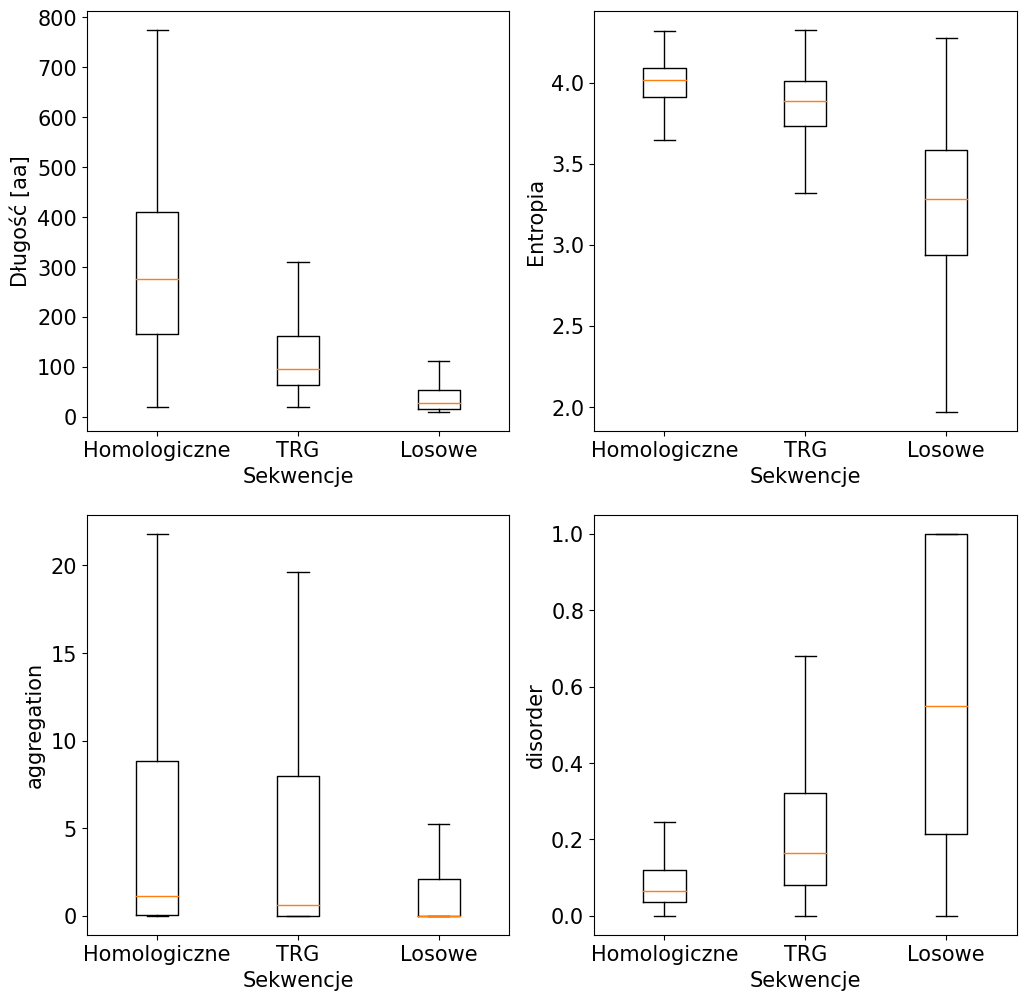

In [248]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.boxplot(x=[length_homologues, length_trg, length_orfs], showfliers=False)
ax1.set(ylabel="Długość [aa]")

ax2.boxplot(x=[entropy_homologues, entropy_trg, entropy_orfs], showfliers=False)
ax2.set(ylabel="Entropia")

ax3.boxplot(
    x=[aggregation_hom_results, aggregation_trg_results, aggregation_orf_results],
    showfliers=False,
)
ax3.set(ylabel="aggregation")

ax4.boxplot(
    x=[disorder_hom_results, disorder_trg_results, disorder_orf_results],
    showfliers=False,
)
ax4.set(ylabel="disorder")

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([1, 2, 3], ["Homologiczne", "TRG", "Losowe"])
    ax.set(xlabel="Sekwencje")

plt.gcf().set_size_inches(12, 12)
plt.rcParams.update({"font.size": 15})
plt.show()
